IMPORTING LIBRARIES

In [8]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns

LOADING DATASETS

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset_paths = [
    '/content/drive/MyDrive/Colab Notebooks/LR-HR DDoS 2024 Dataset for SDN-Based Networks.csv',
    '/content/drive/MyDrive/Colab Notebooks/DDoS-SDN-Tree .csv',
    '/content/drive/MyDrive/Colab Notebooks/SNT_dataset.csv',
    '/content/drive/MyDrive/Colab Notebooks/ DDoS-SDN-Torus.csv'
]

raw_datasets = [pd.read_csv(path, low_memory=False) for path in dataset_paths]

PREPROCESSING

In [10]:
# Standardize label column
for df in raw_datasets:
    if 'Label' in df.columns:
        df.rename(columns={'Label': 'label'}, inplace=True)

# Track all features
all_features = set()
for df in raw_datasets:
    all_features.update(set(df.columns) - {'label'})
all_features = sorted(list(all_features))


In [11]:
# Fill missing features & drop 30% at random
np.random.seed(42)
for i in range(len(raw_datasets)):
    df = raw_datasets[i]
    for feat in all_features:
        if feat not in df.columns:
            df[feat] = 0
    df = df[all_features + ['label']]

    for col in df.columns[:-1]:
        if df[col].dtype == object or df[col].dtype == str:
            df[col] = LabelEncoder().fit_transform(df[col].astype(str))
        else:
            df[col] = df[col].astype(float)

    scaler = StandardScaler()
    df[df.columns[:-1]] = scaler.fit_transform(df[df.columns[:-1]])

    drop_count = int(0.3 * len(df.columns[:-1]))
    drop_cols = np.random.choice(df.columns[:-1], drop_count, replace=False)
    df.drop(columns=drop_cols, inplace=True)

    df[df.columns[:-1]] += np.random.normal(0, 0.15, df[df.columns[:-1]].shape)

    raw_datasets[i] = df

In [12]:
# Align final features — only use common columns across all datasets
common_features = set(raw_datasets[0].columns) - {'label'}
for df in raw_datasets:
    common_features &= set(df.columns) - {'label'}
final_features = sorted(list(common_features))

DEFINING MODEL

In [13]:
class GlobalModel(nn.Module):
    def __init__(self, input_dim):
        super(GlobalModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 2)
        )

    def forward(self, x):
        return self.net(x)

TRAINING MODEL

In [14]:
def train_local_model_kfold(model, X, y, k=3, epochs=2, batch_size=64):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    model.train()

    for train_idx, _ in skf.split(X, y):
        X_train, y_train = X[train_idx], y[train_idx]
        dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                torch.tensor(y_train, dtype=torch.long))
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
        criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        for _ in range(epochs):
            for inputs, labels in loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()


EVALUATION

In [15]:
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        inputs = torch.tensor(X_test, dtype=torch.float32).to(device)
        labels = torch.tensor(y_test, dtype=torch.long).to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        acc = (preds == labels).float().mean().item()
    return acc

PLOTING METRICS

In [16]:
def plot_metrics(y_true, y_pred, y_probs, client_id):
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - Client {client_id}")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_probs[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f"ROC Curve - Client {client_id}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_probs[:, 1])
    avg_precision = average_precision_score(y_true, y_probs[:, 1])
    plt.figure()
    plt.plot(recall, precision, label=f'AP = {avg_precision:.2f}')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve - Client {client_id}")
    plt.legend()
    plt.grid(True)
    plt.show()

MODEL AVERAGING

In [17]:

def average_models(global_model, local_models):
    global_dict = global_model.state_dict()
    for key in global_dict:
        global_dict[key] = torch.stack([local.state_dict()[key] for local in local_models], 0).mean(0)
    global_model.load_state_dict(global_dict)

FEDERATED TRAINING


🌍 Global Round 1/5
📊 Client 1: Accuracy = 0.9918
📊 Client 2: Accuracy = 0.9623
📊 Client 3: Accuracy = 0.9714
📊 Client 4: Accuracy = 0.9837

✅ Final Global Evaluation:

🌍 Global Round 2/5
📊 Client 1: Accuracy = 0.9928
📊 Client 2: Accuracy = 0.9625
📊 Client 3: Accuracy = 0.9711
📊 Client 4: Accuracy = 0.9828

✅ Final Global Evaluation:

🌍 Global Round 3/5
📊 Client 1: Accuracy = 0.9926
📊 Client 2: Accuracy = 0.9635
📊 Client 3: Accuracy = 0.9712
📊 Client 4: Accuracy = 0.9838

✅ Final Global Evaluation:

🌍 Global Round 4/5
📊 Client 1: Accuracy = 0.9924
📊 Client 2: Accuracy = 0.9634
📊 Client 3: Accuracy = 0.9713
📊 Client 4: Accuracy = 0.9836

✅ Final Global Evaluation:

🌍 Global Round 5/5
📊 Client 1: Accuracy = 0.9922
📊 Client 2: Accuracy = 0.9643
📊 Client 3: Accuracy = 0.9709
📊 Client 4: Accuracy = 0.9847

✅ Final Global Evaluation:
🌐 Client 1: Accuracy = 0.9124


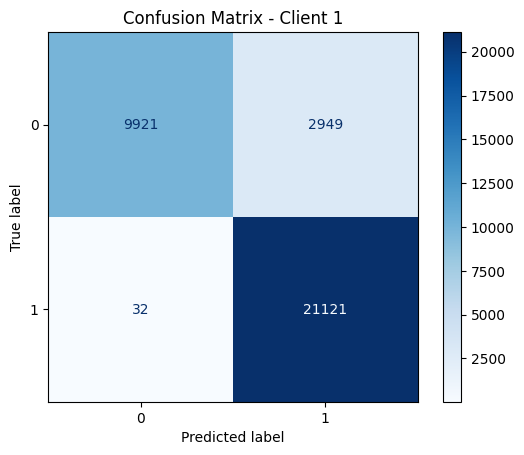

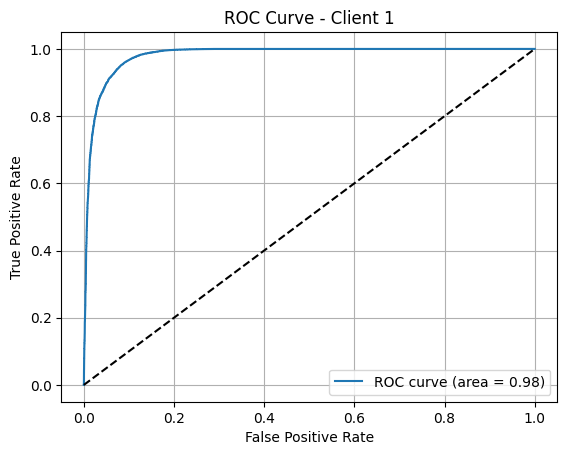

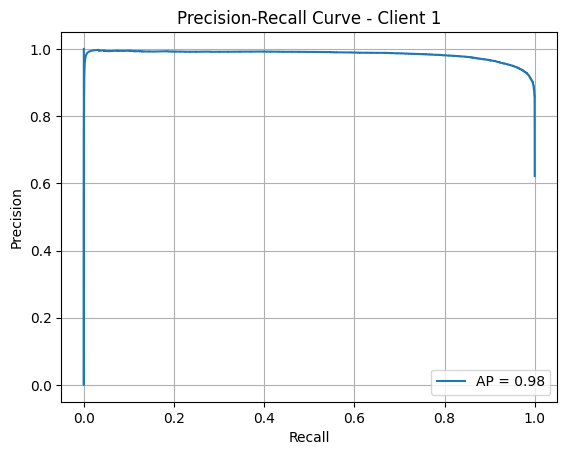

🌐 Client 2: Accuracy = 0.9127


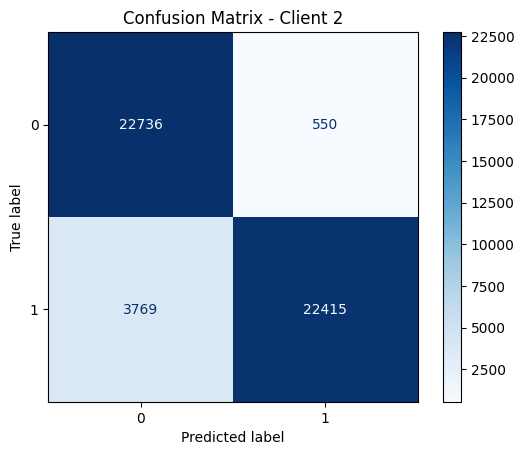

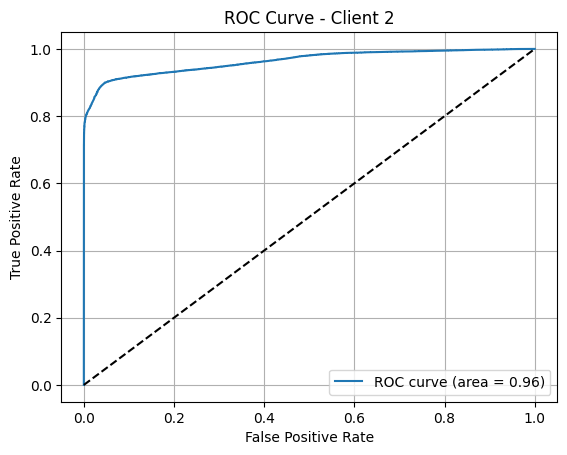

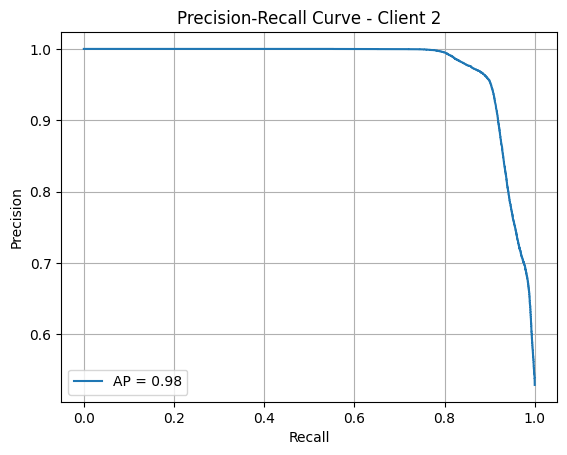

🌐 Client 3: Accuracy = 0.9435


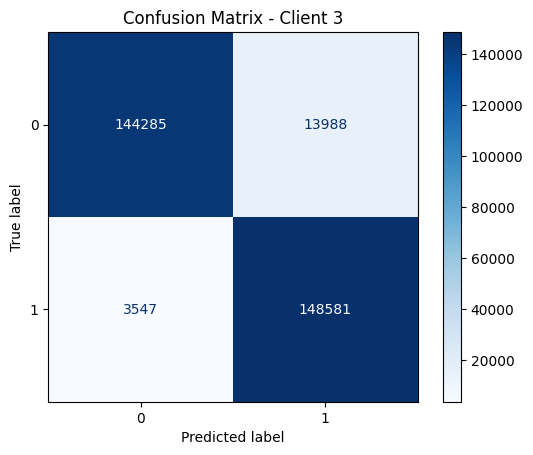

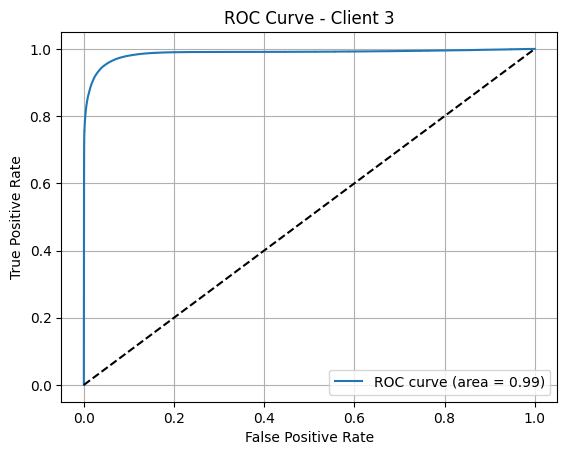

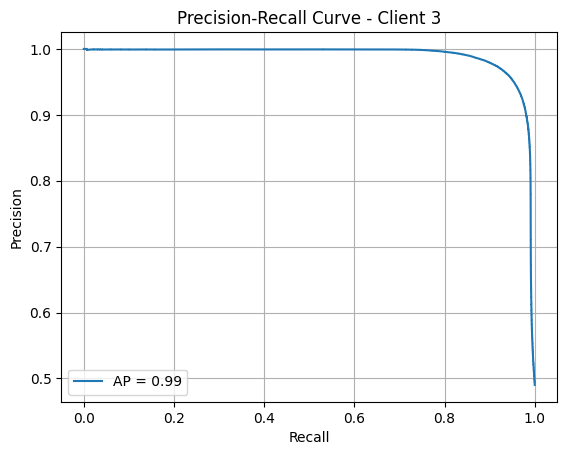

🌐 Client 4: Accuracy = 0.9569


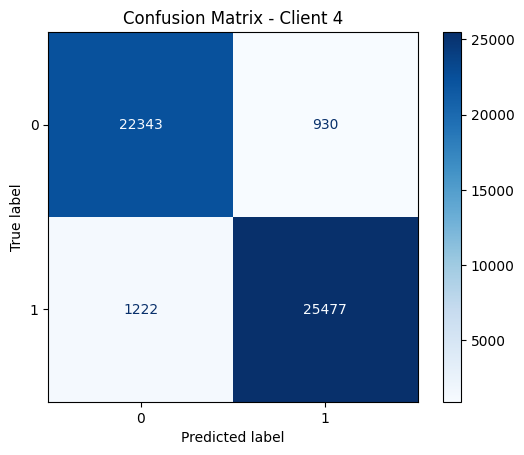

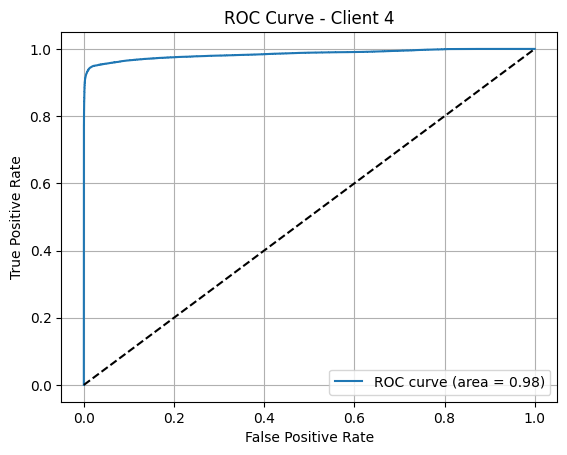

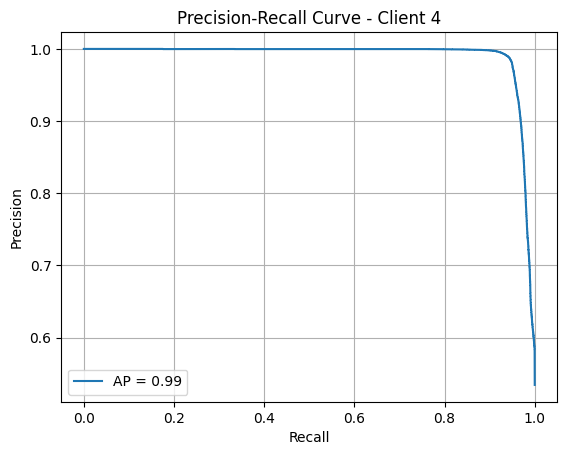

In [7]:
def federated_training(global_rounds=5, local_epochs=2, k_folds=3):
    input_dim = len(final_features)
    global_model = GlobalModel(input_dim).to(device)

    client_test_sets = []

    for round in range(global_rounds):
        print(f"\n🌍 Global Round {round + 1}/{global_rounds}")
        local_models = []

        for i, df in enumerate(raw_datasets):
            X = df[final_features].values
            y = df['label'].values

            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.3, stratify=y, random_state=round
            )

            if round == 0:
                client_test_sets.append((X_test, y_test))

            local_model = GlobalModel(input_dim).to(device)
            local_model.load_state_dict(global_model.state_dict())

            train_local_model_kfold(local_model, X_train, y_train, k=k_folds, epochs=local_epochs)
            acc = evaluate_model(local_model, X_test, y_test)
            print(f"📊 Client {i + 1}: Accuracy = {acc:.4f}")
            local_models.append(local_model)

        average_models(global_model, local_models)

        print("\n✅ Final Global Evaluation:")
    for i, (X_test, y_test) in enumerate(client_test_sets):
        global_model.eval()
        with torch.no_grad():
            X_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
            y_tensor = torch.tensor(y_test, dtype=torch.long).to(device)
            outputs = global_model(X_tensor)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            preds = np.argmax(probs, axis=1)

        acc = (preds == y_test).mean()
        print(f"🌐 Client {i + 1}: Accuracy = {acc:.4f}")
        plot_metrics(y_test, preds, probs, i + 1)


# --- Run Training --- #
if __name__ == "__main__":
    federated_training(global_rounds=5, local_epochs=2, k_folds=3)
